## Setup and Imports

This section includes all necessary imports and initial setup configurations for the analysis.


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import bisect
from scipy.integrate import romb

## Load Data by Category

This section loads the standardized data from the CSV file and splits it into separate DataFrames for each category of equipment or personnel losses. This approach facilitates focused analysis on specific categories without interference from unrelated data.


In [47]:
import pandas as pd

# Load the complete standardized data
df_complete = pd.read_csv('standardized_data.csv')

# List of categories to create separate DataFrames for
categories = ['Tanks', 'Aircraft', 'Artillery', 'AirDefense', 'Vehicles', 'Personnel']

# Dictionary to hold the DataFrames for each category
category_dfs = {}

for category in categories:
    # Assuming the columns are named like 'RUS-Tanks-Documented' and 'RUS-Tanks-Claimed-UKR'
    category_columns = [col for col in df_complete.columns if category in col] + ['Date']
    category_dfs[category] = df_complete[category_columns].copy()

    # Display the first few rows of each category DataFrame
    print(f"DataFrame for {category}:")
    print(category_dfs[category].head(), '\n')


DataFrame for Tanks:
   RUS-Tanks-Documented  RUS-Tanks-Claimed-UKR        Date
0                     1                    0.0  2022-02-24
1                     2                    0.0  2022-02-25
2                     7                    0.0  2022-02-26
3                     9                  150.0  2022-02-27
4                    41                  191.0  2022-02-28 

DataFrame for Aircraft:
   RUS-Aircraft-Documented  RUS-Aircraft-Claimed-UKR        Date
0                        4                      13.0  2022-02-24
1                        5                      17.0  2022-02-25
2                        5                      34.0  2022-02-26
3                        6                      55.0  2022-02-27
4                        7                      61.0  2022-02-28 

DataFrame for Artillery:
   RUS-Artillery-Documented  RUS-Artillery-Claimed-UKR        Date
0                         0                        0.0  2022-02-24
1                         4                     

In [48]:
def clean_data(df, category):
    """Cleans data for the specified category of losses within the given DataFrame by removing rows with missing values.
    
    Args:
        df (DataFrame): The DataFrame to clean.
        category (str): The category to clean, e.g., 'Tanks', 'Aircraft'.
    """
    documented_col = f'RUS-{category}-Documented'
    claimed_col = f'RUS-{category}-Claimed-UKR'

    # Check for missing values and report them
    initial_missing = df[[documented_col, claimed_col]].isnull().sum()
    print(f"Initial missing values for {category}:")
    print(initial_missing)

    # Drop rows with missing values in either documented or claimed columns
    before_drop = len(df)
    df.dropna(subset=[documented_col, claimed_col], inplace=True)
    after_drop = len(df)

    # Convert data types to integer
    df[documented_col] = df[documented_col].astype(int)
    df[claimed_col] = df[claimed_col].astype(int)

    # Verify changes and report how many rows were dropped
    print(f"Dropped {before_drop - after_drop} rows due to missing data in {category}.")
    print(f"Data types after conversion for {category}:")
    print(df[[documented_col, claimed_col]].dtypes)
    print("\nSample data after cleaning:")
    print(df[[documented_col, claimed_col]].head())

# Apply the cleaning function to each category-specific DataFrame
for category, df in category_dfs.items():
    clean_data(df, category)


Initial missing values for Tanks:
RUS-Tanks-Documented      0
RUS-Tanks-Claimed-UKR    15
dtype: int64
Dropped 15 rows due to missing data in Tanks.
Data types after conversion for Tanks:
RUS-Tanks-Documented     int64
RUS-Tanks-Claimed-UKR    int64
dtype: object

Sample data after cleaning:
   RUS-Tanks-Documented  RUS-Tanks-Claimed-UKR
0                     1                      0
1                     2                      0
2                     7                      0
3                     9                    150
4                    41                    191
Initial missing values for Aircraft:
RUS-Aircraft-Documented      0
RUS-Aircraft-Claimed-UKR    15
dtype: int64
Dropped 15 rows due to missing data in Aircraft.
Data types after conversion for Aircraft:
RUS-Aircraft-Documented     int64
RUS-Aircraft-Claimed-UKR    int64
dtype: object

Sample data after cleaning:
   RUS-Aircraft-Documented  RUS-Aircraft-Claimed-UKR
0                        4                        13
1    

## Define Analysis Functions

This section defines all necessary functions for performing comprehensive analysis, including error analysis, numerical differentiation, and plotting.


In [49]:
def compute_errors(df, documented_col, claimed_col):
    mae = mean_absolute_error(df[documented_col], df[claimed_col])
    mse = mean_squared_error(df[documented_col], df[claimed_col])
    print(f"Mean Absolute Error: {mae}, Mean Squared Error: {mse}")

def numerical_differentiation(df, column):
    derivatives = np.zeros(len(df))
    for i in range(1, len(df)-1):
        derivatives[i] = (df[column].iloc[i+1] - df[column].iloc[i-1]) / 2
    return derivatives

def plot_derivatives(df, category):
    documented_col = f'RUS-{category}-Documented'
    claimed_col = f'RUS-{category}-Claimed-UKR'
    doc_derivatives = numerical_differentiation(df, documented_col)
    claim_derivatives = numerical_differentiation(df, claimed_col)
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'][1:-1], doc_derivatives[1:-1], label=f'Rate of Change in Documented {category}')
    plt.plot(df['Date'][1:-1], claim_derivatives[1:-1], label=f'Rate of Change in Claimed {category}', linestyle='--')
    plt.title('Numerical Differentiation of Documented and Claimed Losses')
    plt.xlabel('Date')
    plt.ylabel('Rate of Change')
    plt.legend()
    plt.grid(True)
    plt.show()


Mean Absolute Error: 1859.6443037974684, Mean Squared Error: 4653044.879746836


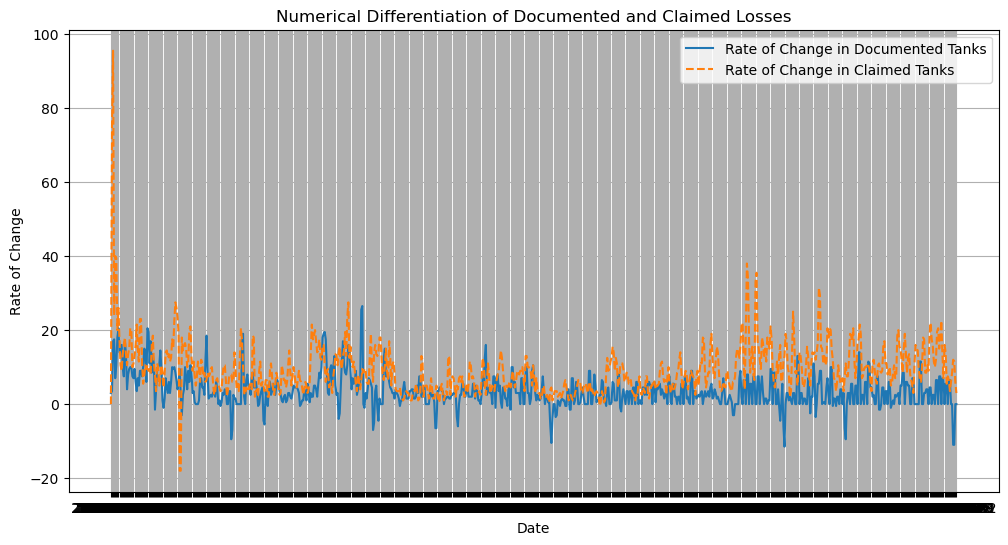

In [50]:
selected_category = 'Tanks'  # User can change this as needed
category_df = category_dfs[selected_category]
documented_col = f'RUS-{selected_category}-Documented'
claimed_col = f'RUS-{selected_category}-Claimed-UKR'

compute_errors(category_df, documented_col, claimed_col)
plot_derivatives(category_df, selected_category)


In [51]:
from scipy.interpolate import CubicSpline

def apply_cubic_spline_interpolation(df, category):
    documented_col = f'RUS-{category}-Documented'
    claimed_col = f'RUS-{category}-Claimed-UKR'
    cs_documented = CubicSpline(np.arange(len(df)), df[documented_col])
    cs_claimed = CubicSpline(np.arange(len(df)), df[claimed_col])

    x_new = np.linspace(0, len(df) - 1, len(df)*10)  # Increased resolution
    y_smoothed_documented = cs_documented(x_new)
    y_smoothed_claimed = cs_claimed(x_new)

    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df[documented_col], 'o', label='Original Documented', markersize=3)
    plt.plot(df['Date'], df[claimed_col], 'o', label='Original Claimed', markersize=3)
    plt.plot(x_new, y_smoothed_documented, label='Smoothed Documented')
    plt.plot(x_new, y_smoothed_claimed, label='Smoothed Claimed')
    plt.title(f'Cubic Spline Interpolation for {category}')
    plt.xlabel('Date')
    plt.ylabel('Number of Units')
    plt.legend()
    plt.grid(True)
    plt.show()

    return x_new, y_smoothed_documented, y_smoothed_claimed


In [52]:
from scipy.integrate import trapz

def integrate_smoothed_data(x_new, y_smoothed_documented, y_smoothed_claimed):
    total_documented = trapz(y_smoothed_documented, x_new)
    total_claimed = trapz(y_smoothed_claimed, x_new)

    print(f"Total Integrated Documented Losses: {total_documented}")
    print(f"Total Integrated Claimed Losses: {total_claimed}")

    discrepancy = total_documented - total_claimed
    print(f"Integrated Discrepancy: {discrepancy}")


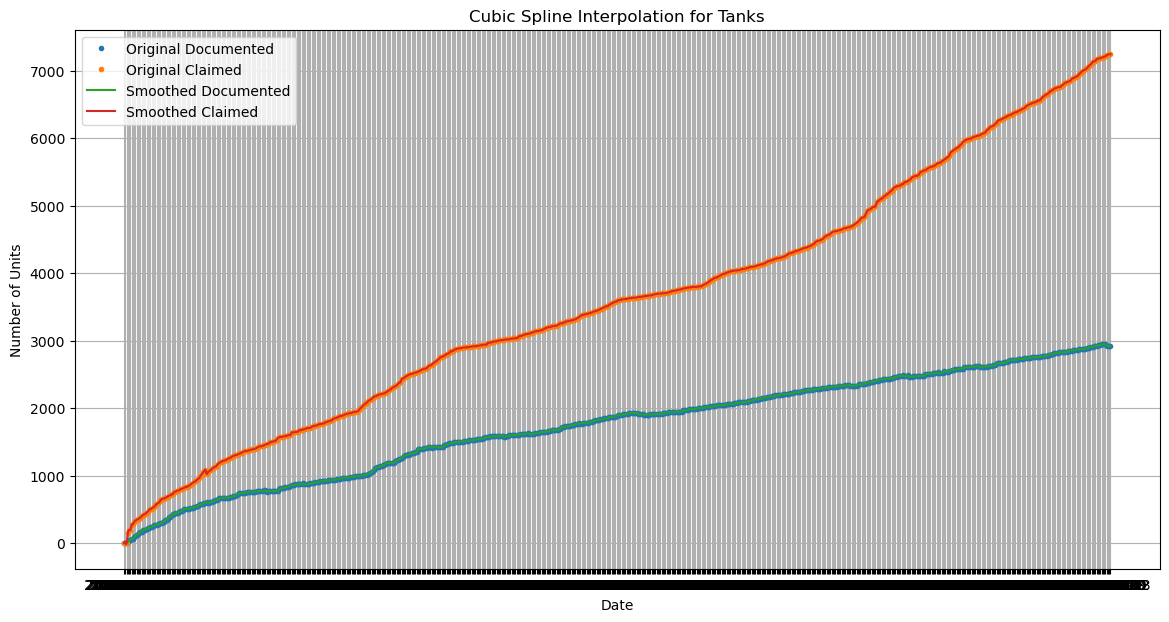

Total Integrated Documented Losses: 1372196.3602759833
Total Integrated Claimed Losses: 2839145.009639313
Integrated Discrepancy: -1466948.6493633296


In [53]:
selected_category = 'Tanks'
category_df = category_dfs[selected_category]

# Apply cubic spline interpolation and capture the new x values and smoothed y values
x_new, y_smoothed_documented, y_smoothed_claimed = apply_cubic_spline_interpolation(category_df, selected_category)

# Perform numerical integration on the smoothed data
integrate_smoothed_data(x_new, y_smoothed_documented, y_smoothed_claimed)


## Analysis of [Category Name]

Perform detailed analysis for the selected category, applying statistical methods, visualizations, and other data processing techniques.


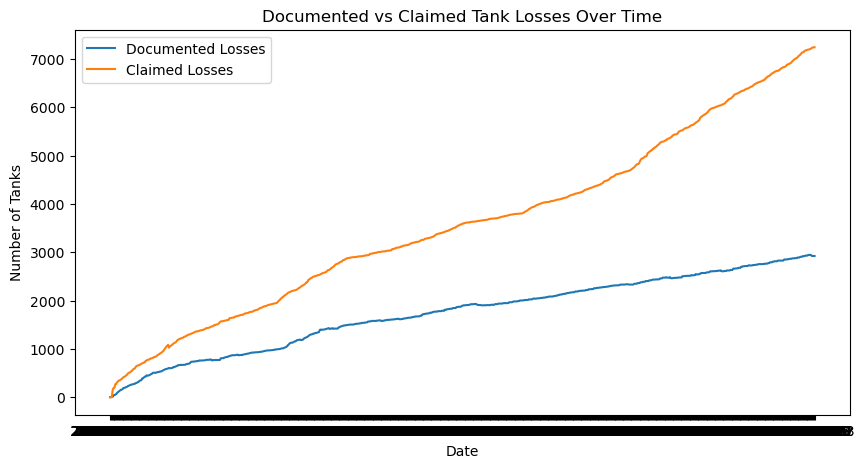

In [54]:
# Replace '[Category]' with the specific category you want to analyze, e.g., 'Tanks'
current_category_df = category_dfs['Tanks']  # Example for Tanks

# Perform analysis, e.g., plotting data, statistical tests, etc.
# Example: Plotting data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(current_category_df['Date'], current_category_df['RUS-Tanks-Documented'], label='Documented Losses')
plt.plot(current_category_df['Date'], current_category_df['RUS-Tanks-Claimed-UKR'], label='Claimed Losses')
plt.title('Documented vs Claimed Tank Losses Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tanks')
plt.legend()
plt.show()


## Define Error Analysis Function

This function calculates the Mean Absolute Error (MAE) and Mean Squared Error (MSE) for a given category.


In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_errors(df, documented_col, claimed_col):
    """Calculates and prints the mean absolute error and mean squared error between documented and claimed data."""
    mae = mean_absolute_error(df[documented_col], df[claimed_col])
    mse = mean_squared_error(df[documented_col], df[claimed_col])
    print(f"Mean Absolute Error between {documented_col} and {claimed_col}: {mae}")
    print(f"Mean Squared Error between {documented_col} and {claimed_col}: {mse}")



## Define Root Finding Function

Uses Newton's method to find a crossing point where the absolute discrepancy between documented and claimed data equals a specified threshold.

In [56]:
from scipy.optimize import newton


def find_threshold_crossing(df, documented_col, claimed_col, threshold):
    def discrepancy(x):
        return abs(df.iloc[int(x)][documented_col] - df.iloc[int(x)][claimed_col]) - threshold

    try:
        crossing_index = newton(discrepancy, x0=0)
        print(f"Threshold of {threshold} crossed at index: {crossing_index}, Date: {df.iloc[int(crossing_index)]['Date']}")
    except RuntimeError:
        print("No crossing point found within the data range.")


## Define Interpolation Function

This function uses cubic spline interpolation to smooth the data for a given category.


In [57]:
from scipy.interpolate import CubicSpline
import numpy as np


def apply_and_plot_interpolation(df, category):
    """Applies cubic spline interpolation to both documented and claimed data and plots them for comparison."""
    documented_col = f'RUS-{category}-Documented'
    claimed_col = f'RUS-{category}-Claimed-UKR'
    x_new = np.linspace(0, len(df) - 1, 300)
    cs_documented = CubicSpline(np.arange(len(df)), df[documented_col])
    cs_claimed = CubicSpline(np.arange(len(df)), df[claimed_col])

    y_smoothed_documented = cs_documented(x_new)
    y_smoothed_claimed = cs_claimed(x_new)

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df[documented_col], 'o', label='Original Documented', markersize=5)
    plt.plot(df['Date'], df[claimed_col], 'o', label='Original Claimed', markersize=5)
    plt.plot(x_new, y_smoothed_documented, label='Smoothed Documented')
    plt.plot(x_new, y_smoothed_claimed, label='Smoothed Claimed')
    plt.title(f'Cubic Spline Interpolation Comparison for {category}')
    plt.xlabel('Date')
    plt.ylabel('Number of Units')
    plt.legend()
    plt.show()


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect
from scipy.integrate import romb
from sklearn.metrics import mean_absolute_error, mean_squared_error

def perform_comprehensive_analysis(df, category):
    documented_col = f'RUS-{category}-Documented'
    claimed_col = f'RUS-{category}-Claimed-UKR'

    # Compute basic error metrics
    mae = mean_absolute_error(df[documented_col], df[claimed_col])
    mse = mean_squared_error(df[documented_col], df[claimed_col])
    print(f"Mean Absolute Error: {mae}, Mean Squared Error: {mse}")

    # Bisection Method to find when discrepancy is zero
    def discrepancy(index):
        return df.iloc[int(index)][documented_col] - df.iloc[int(index)][claimed_col]

    index_zero_discrepancy = bisect(discrepancy, 0, len(df)-1)
    print(f"Zero discrepancy occurs at index: {index_zero_discrepancy}")

    # Richardson's Extrapolation for rate of change
    def richardson_extrapolation(f, x, h=1):
        D1 = (f(x + h) - f(x - h)) / (2 * h)
        D2 = (f(x + 0.5 * h) - f(x - 0.5 * h)) / h
        return (4 * D2 - D1) / 3

    rates_of_change = [richardson_extrapolation(lambda x: df.iloc[x][documented_col], i) for i in range(1, len(df)-1)]
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'][1:-1], rates_of_change, label='Rate of Change of Documented Losses')
    plt.title('Rate of Change Using Richardson’s Extrapolation')
    plt.xlabel('Date')
    plt.ylabel('Rate of Change')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Romberg Integration to calculate the total discrepancy over time
    discrepancies = df[documented_col] - df[claimed_col]
    total_discrepancy = romb(discrepancies.dropna().values, dx=1)  # Ensure no NaN values and equal spacing
    print(f"Total discrepancy calculated by Romberg Integration: {total_discrepancy}")



## Interactive Analysis Execution

Set the category below to perform the defined numerical analyses on the chosen category.


In [59]:
selected_category = 'Tanks'  # The category to analyze
perform_comprehensive_analysis(category_dfs[selected_category], selected_category)


Mean Absolute Error: 1859.6443037974684, Mean Squared Error: 4653044.879746836
Zero discrepancy occurs at index: 3.0000000000004636


TypeError: Cannot index by location index with a non-integer key